# Data Analysis
The notebook focuses on connecting to GCP to access the data from the bucket.

To make the connection, we use a [GCP service account ](https://cloud.google.com/iam/docs/service-account-overview)that holds permissions to access our bucket.
### Steps
1. Access Service accounts in the GCP account
2. Open `deng-capstone-service-account`
3. Create a new key file and download it locally for access in the next step. Rename file to a concise name.
4. Set path of the key file as option in your spark configuration -    `spark._jsc.hadoopConfiguration().set("google.cloud.auth.service.account.json.keyfile","/path/to/file/<renamed>.json")`

### Resources
1. https://gobiviswa.medium.com/google-cloud-storage-handson-connecting-using-pyspark-5eefc0d8d932
2. https://cloud.google.com/iam/docs/service-account-overview


## Spark Application setup

In [46]:
from datetime import datetime, timedelta

from pyspark import SparkConf
from pyspark.sql import SparkSession


spark = SparkSession.builder \
    .appName('data-engineering-capstone') \
    .config("spark.jars", "https://storage.googleapis.com/hadoop-lib/gcs/gcs-connector-hadoop3-latest.jar") \
    .config("spark.sql.repl.eagerEval.enabled", True) \
    .getOrCreate()

# Set GCS credentials. Ensure path points to you downloaded key file
spark._jsc.hadoopConfiguration().set(
    "google.cloud.auth.service.account.json.keyfile",
    "C:\pro\gcp-key.json")



## Read from GCS

In [47]:
# file path to data in GCS bucket

file_path = "gs://ecommerce-customer/e-commerce-customer-behavior.csv"


df = spark.read.csv(file_path, header=True, inferSchema=True)

df.show(5)

+-----------+------+---+-------------+---------------+-----------+---------------+--------------+----------------+------------------------+------------------+
|Customer ID|Gender|Age|         City|Membership Type|Total Spend|Items Purchased|Average Rating|Discount Applied|Days Since Last Purchase|Satisfaction Level|
+-----------+------+---+-------------+---------------+-----------+---------------+--------------+----------------+------------------------+------------------+
|        101|Female| 29|     New York|           Gold|     1120.2|             14|           4.6|            true|                      25|         Satisfied|
|        102|  Male| 34|  Los Angeles|         Silver|      780.5|             11|           4.1|           false|                      18|           Neutral|
|        103|Female| 43|      Chicago|         Bronze|     510.75|              9|           3.4|            true|                      42|       Unsatisfied|
|        104|  Male| 30|San Francisco|        

In [48]:
# Describe the dataset
df.describe().show()


+-------+------------------+------+------------------+-------------+---------------+-----------------+-----------------+------------------+------------------------+------------------+
|summary|       Customer ID|Gender|               Age|         City|Membership Type|      Total Spend|  Items Purchased|    Average Rating|Days Since Last Purchase|Satisfaction Level|
+-------+------------------+------+------------------+-------------+---------------+-----------------+-----------------+------------------+------------------------+------------------+
|  count|               350|   350|               350|          350|            350|              350|              350|               350|                     350|               348|
|   mean|             275.5|  NULL|33.597142857142856|         NULL|           NULL|845.3817142857134|             12.6| 4.019142857142849|      26.588571428571427|              NULL|
| stddev|101.18053172424031|  NULL| 4.870882183548376|         NULL|           N

In [49]:
# Drop all rows that contain any null values in any column
df = df.dropna()


In [50]:
df = df.dropDuplicates()


In [51]:
df.describe().show()

+-------+------------------+------+------------------+-------------+---------------+-----------------+------------------+------------------+------------------------+------------------+
|summary|       Customer ID|Gender|               Age|         City|Membership Type|      Total Spend|   Items Purchased|    Average Rating|Days Since Last Purchase|Satisfaction Level|
+-------+------------------+------+------------------+-------------+---------------+-----------------+------------------+------------------+------------------------+------------------+
|  count|               348|   348|               348|          348|            348|              348|               348|               348|                     348|               348|
|   mean|275.88793103448273|  NULL|33.577586206896555|         NULL|           NULL|847.7931034482757|12.632183908045977| 4.023563218390801|      26.614942528735632|              NULL|
| stddev|101.30461140521022|  NULL|4.8780237566708236|         NULL|       

In [52]:
# Segmentation based on spending habits, demographics, loyalty, and satisfaction
from pyspark.sql.functions import when

segmentation_df = df.withColumn("SpendingCategory", 
                                when(df["Total Spend"] > 1000, "High")
                                .when(df["Total Spend"] > 500, "Medium")
                                .otherwise("Low"))

segmentation_df.show()


+-----------+------+---+-------------+---------------+-----------+---------------+--------------+----------------+------------------------+------------------+----------------+
|Customer ID|Gender|Age|         City|Membership Type|Total Spend|Items Purchased|Average Rating|Discount Applied|Days Since Last Purchase|Satisfaction Level|SpendingCategory|
+-----------+------+---+-------------+---------------+-----------+---------------+--------------+----------------+------------------------+------------------+----------------+
|        251|Female| 30|     New York|           Gold|     1180.8|             16|           4.7|            true|                      19|         Satisfied|            High|
|        151|Female| 43|      Chicago|         Bronze|     505.75|             10|           3.3|            true|                      39|       Unsatisfied|          Medium|
|        324|Female| 43|      Chicago|         Bronze|     505.75|             10|           3.3|            true|      

In [53]:
from pyspark.sql.functions import current_date, datediff

# Identify inactive customers (no purchase in the last 30 days)
inactive_customers = segmentation_df.filter((segmentation_df["Days Since Last Purchase"]) > 30)

# Identify recent customers (purchased within the last 7 days)
recent_customers = segmentation_df.filter((segmentation_df["Days Since Last Purchase"]) <= 30)




In [54]:
inactive_customers.show()

+-----------+------+---+--------+---------------+-----------+---------------+--------------+----------------+------------------------+------------------+----------------+
|Customer ID|Gender|Age|    City|Membership Type|Total Spend|Items Purchased|Average Rating|Discount Applied|Days Since Last Purchase|Satisfaction Level|SpendingCategory|
+-----------+------+---+--------+---------------+-----------+---------------+--------------+----------------+------------------------+------------------+----------------+
|        151|Female| 43| Chicago|         Bronze|     505.75|             10|           3.3|            true|                      39|       Unsatisfied|          Medium|
|        324|Female| 43| Chicago|         Bronze|     505.75|             10|           3.3|            true|                      39|       Unsatisfied|          Medium|
|        235|Female| 41| Chicago|         Bronze|     480.25|              9|           3.6|            true|                      38|       Unsa

In [55]:
recent_customers.show()

+-----------+------+---+-------------+---------------+-----------+---------------+--------------+----------------+------------------------+------------------+----------------+
|Customer ID|Gender|Age|         City|Membership Type|Total Spend|Items Purchased|Average Rating|Discount Applied|Days Since Last Purchase|Satisfaction Level|SpendingCategory|
+-----------+------+---+-------------+---------------+-----------+---------------+--------------+----------------+------------------------+------------------+----------------+
|        251|Female| 30|     New York|           Gold|     1180.8|             16|           4.7|            true|                      19|         Satisfied|            High|
|        144|  Male| 35|  Los Angeles|         Silver|      820.9|             12|           4.3|           false|                      12|           Neutral|          Medium|
|        385|  Male| 28|San Francisco|           Gold|     1490.1|             21|           4.9|           false|      

In [56]:
from datetime import datetime

# Get current datetime in the format MMDDYYYYHHMMSS
datetime_now = datetime.now().strftime("%m%d%Y%H%M%S")

# Define the base output path using formatted strings
base_output_path = f"gs://ecommerce-customer/output/{datetime_now}"

# Write inactive customers to GCS with overwrite mode
inactive_customers_output_path = f"{base_output_path}/inactive_customers"
inactive_customers.write.csv(inactive_customers_output_path, header=True, mode='overwrite')

# Write recent customers to GCS with overwrite mode
recent_customers_output_path = f"{base_output_path}/recent_customers"
recent_customers.write.csv(recent_customers_output_path, header=True, mode='overwrite')



In [57]:

df = segmentation_df
df.show()

+-----------+------+---+-------------+---------------+-----------+---------------+--------------+----------------+------------------------+------------------+----------------+
|Customer ID|Gender|Age|         City|Membership Type|Total Spend|Items Purchased|Average Rating|Discount Applied|Days Since Last Purchase|Satisfaction Level|SpendingCategory|
+-----------+------+---+-------------+---------------+-----------+---------------+--------------+----------------+------------------------+------------------+----------------+
|        251|Female| 30|     New York|           Gold|     1180.8|             16|           4.7|            true|                      19|         Satisfied|            High|
|        151|Female| 43|      Chicago|         Bronze|     505.75|             10|           3.3|            true|                      39|       Unsatisfied|          Medium|
|        324|Female| 43|      Chicago|         Bronze|     505.75|             10|           3.3|            true|      

<Figure size 800x500 with 0 Axes>

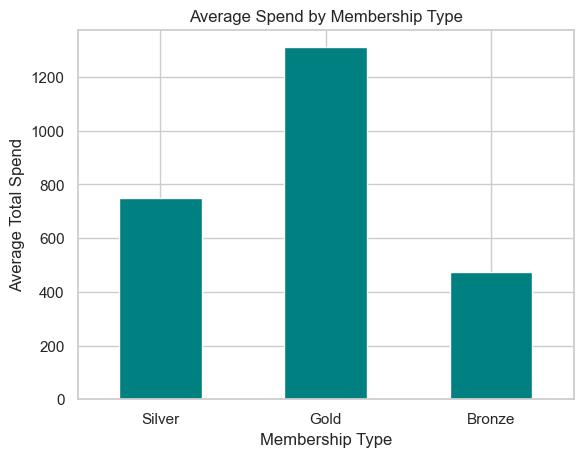

In [58]:
# Spending Behavior Analysis: Plotting Average Spend by Membership Type

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean

# Assuming df is a Spark DataFrame
# Group by 'Membership Type' and calculate the average 'Total Spend'
spend_by_membership = df.groupBy('Membership Type').agg({'Total Spend': 'mean'})

# Convert to Pandas DataFrame for plotting
spend_by_membership_pd = spend_by_membership.toPandas()

# Rename the columns for clarity
spend_by_membership_pd.columns = ['Membership Type', 'Average Total Spend']

# Set the index to 'Membership Type' for easier plotting
spend_by_membership_pd.set_index('Membership Type', inplace=True)

# Plotting
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 5))
spend_by_membership_pd.plot(kind='bar', color='teal', legend=False)
plt.title('Average Spend by Membership Type')
plt.xlabel('Membership Type')
plt.ylabel('Average Total Spend')
plt.xticks(rotation=0)
plt.show()


<Figure size 800x500 with 0 Axes>

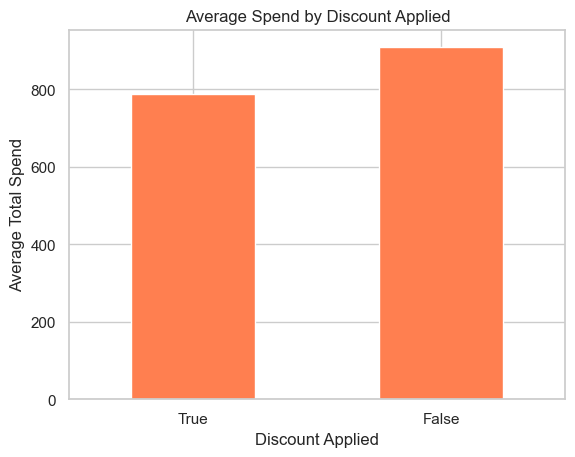

In [59]:
# Plotting Average Spend by Discount Applied

# Assuming df is a Spark DataFrame
# Group by 'Discount Applied' and calculate the average 'Total Spend'
spend_by_discount = df.groupBy('Discount Applied').agg({'Total Spend': 'mean'})

# Convert to Pandas DataFrame for plotting
spend_by_discount_pd = spend_by_discount.toPandas()

# Rename the columns for clarity
spend_by_discount_pd.columns = ['Discount Applied', 'Average Total Spend']

# Set the index to 'Discount Applied' for easier plotting
spend_by_discount_pd.set_index('Discount Applied', inplace=True)

# Plotting
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 5))
spend_by_discount_pd.plot(kind='bar', color='coral', legend=False)
plt.title('Average Spend by Discount Applied')
plt.xlabel('Discount Applied')
plt.ylabel('Average Total Spend')
plt.xticks(rotation=0)
plt.show()



<Figure size 800x500 with 0 Axes>

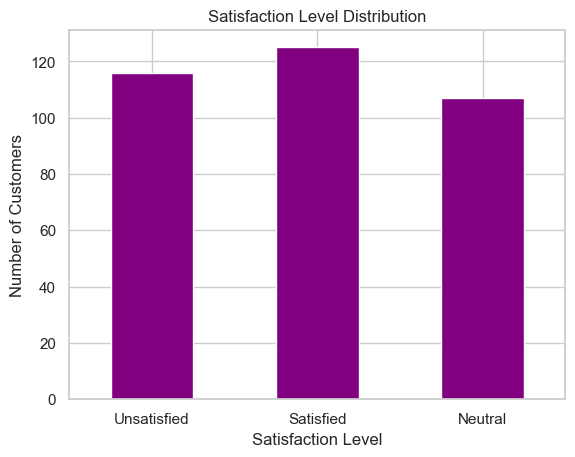

In [60]:
# Satisfaction Analysis: Satisfaction Level Distribution

# Initialize Spark session (skip if already initialized)
spark = SparkSession.builder.master("local").appName("example").getOrCreate()

# Calculate Satisfaction Level Distribution
satisfaction_distribution = df.groupBy('Satisfaction Level').count()

# Convert to Pandas DataFrame for plotting
satisfaction_distribution_pd = satisfaction_distribution.toPandas()

# Rename columns for clarity
satisfaction_distribution_pd.columns = ['Satisfaction Level', 'Number of Customers']

# Plotting
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 5))
satisfaction_distribution_pd.plot(kind='bar', x='Satisfaction Level', y='Number of Customers', color='purple', legend=False)
plt.title('Satisfaction Level Distribution')
plt.xlabel('Satisfaction Level')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)
plt.show()

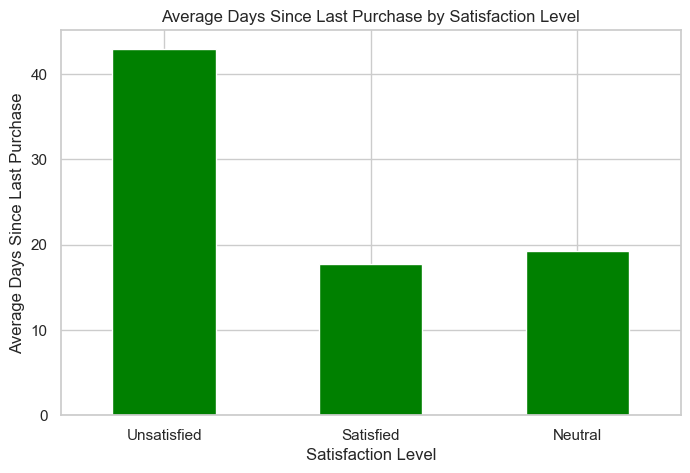

In [61]:
# Churn Prediction Indicators: Average Days Since Last Purchase by Satisfaction Level

# Set the theme for the plots
sns.set_theme(style="whitegrid")

# Calculate Average Days Since Last Purchase by Satisfaction Level
avg_days_since_purchase_spark = (df
    .groupBy('Satisfaction Level')
    .agg(mean('Days Since Last Purchase').alias('Average Days Since Last Purchase'))
    .toPandas()
)

# Plotting
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 5))
avg_days_since_purchase_spark.set_index('Satisfaction Level')['Average Days Since Last Purchase'].plot(kind='bar', color='green')
plt.title('Average Days Since Last Purchase by Satisfaction Level')
plt.xlabel('Satisfaction Level')
plt.ylabel('Average Days Since Last Purchase')
plt.xticks(rotation=0)
plt.show()